In [80]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import torch

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
# Render the figure in a notebook:
%matplotlib inline  

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import plot_tree

from sklearn import metrics

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn as nn
import torch.nn.functional as F

from torchmetrics.classification import Accuracy
from torchmetrics.classification import Recall
from torchmetrics import R2Score
from torchmetrics import MeanAbsoluteError

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [81]:
x_train = pd.read_csv('../no_nontoxic_nans_X_train.csv')
y_train = pd.read_csv('../no_nontoxic_nans_y_train.csv')

x_val = pd.read_csv('../no_nontoxic_nans_X_val.csv')
y_val = pd.read_csv('../no_nontoxic_nans_y_val.csv')

x_test = pd.read_csv('../no_nontoxic_nans_x_test.csv')
y_test = pd.read_csv('../no_nontoxic_nans_y_test.csv')

In [82]:
DTC_gini = DecisionTreeClassifier(criterion='gini', max_depth=10)
def get_model_matrics(x_data,y_data,model):
    DTC_gini_pred = DTC_gini.predict(x_data.drop(columns='Unnamed: 0'))
    DTC_gini_acc = metrics.accuracy_score(y_data.drop(columns='Unnamed: 0'), DTC_gini_pred)
    print('accuracy:', DTC_gini_acc)

DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
get_model_matrics(x_train, y_train, DTC_gini)
get_model_matrics(x_val,y_val,DTC_gini)
get_model_matrics(x_test,y_test, DTC_gini)

accuracy: 0.9133026280140883
accuracy: 0.7676767676767676
accuracy: 0.7550505050505051


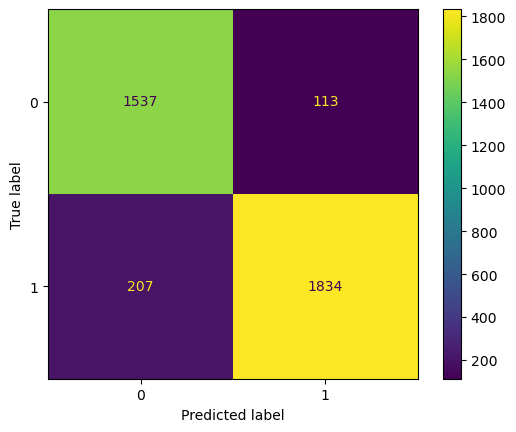

In [83]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
DTC_gini_y_pred = DTC_gini.predict(x_train.drop(columns='Unnamed: 0'))
ConfusionMatrixDisplay.from_predictions(y_train.drop(columns='Unnamed: 0'),DTC_gini_y_pred)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


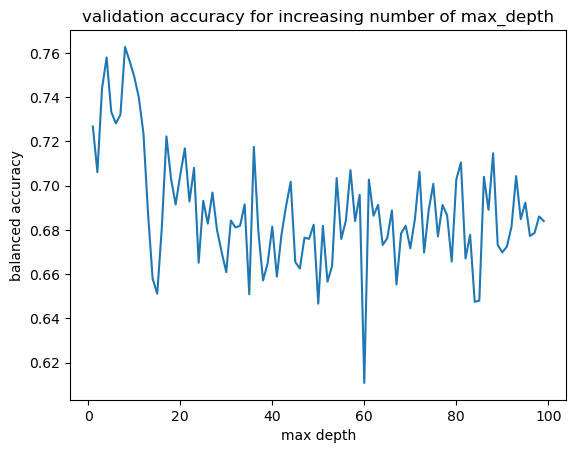

In [104]:
#learning curve
acc_list = []
i_list = []
for i in range(1,100): #number of iterations:
    print(i)
    DTC_gini_i = DecisionTreeClassifier(criterion='gini', max_depth=i) #new GINI model with i learning depth
    DTC_gini_i.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0')) #fit the model to training data.
    
    DTC_gini_pred_val = DTC_gini_i.predict(x_val.drop(columns='Unnamed: 0'))
    DTC_gini_acc_val = metrics.balanced_accuracy_score(y_val.drop(columns='Unnamed: 0'), DTC_gini_pred_val)
    acc_list.append(DTC_gini_acc_val)
    i_list.append(i)
plt.plot(i_list, acc_list)
plt.title('validation accuracy for increasing number of max_depth')
plt.xlabel('max depth')
plt.ylabel('balanced accuracy')
plt.show()
# DTC_gini.fit(x_train.drop(columns='Unnamed: 0'), y_train.drop(columns='Unnamed: 0'))
# get_model_metrics(x_train, y_train, DTC_gini)
# get_model_metrics(x_val,y_val,DTC_gini)

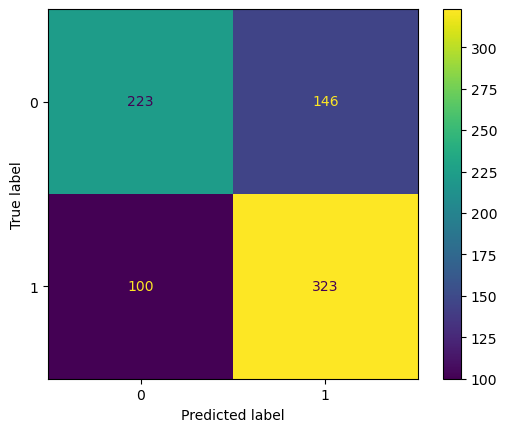

In [109]:
DTC_gini_7 = DecisionTreeClassifier(criterion='gini', max_depth=7) #new GINI model with i learning depth
ConfusionMatrixDisplay.from_predictions(y_val.drop(columns='Unnamed: 0'),DTC_gini_i.predict(x_val.drop(columns='Unnamed: 0')))

this isn't great. Who knows?